# SCDC vs MPBP

## Module load

In [2]:
using Pkg
Pkg.activate("..")

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`


In [3]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions

In [4]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end

sort_by_infection_time (generic function with 1 method)

## Data load

In [6]:
using JLD

data_config = load("test_data.jld")
data_beliefs_mpbp = load("beliefs_mpbp.jld");

In [11]:
const T::Int = 20 # total time

G = data_config["G"]
obsmat = data_config["obsmat"]
config = data_config["config"]

beliefs_mpbp = data_beliefs_mpbp["b_bp"]

NV = nv(G)

obslist = []
for i in 1:NV
    for t in 1:T+1
        if obsmat[i, t] >= 0.0
            push!(obslist, (i, t-1))
        end
    end
end
    
obslist

75-element Vector{Any}:
 (2, 10)
 (3, 10)
 (5, 10)
 (6, 10)
 (7, 10)
 (9, 10)
 (10, 10)
 (11, 10)
 (13, 10)
 (16, 10)
 (17, 10)
 (19, 10)
 (21, 10)
 ⋮
 (88, 10)
 (89, 10)
 (90, 10)
 (91, 10)
 (92, 10)
 (93, 10)
 (95, 10)
 (96, 10)
 (97, 10)
 (98, 10)
 (99, 10)
 (100, 10)

## - SIRS:

### System parameter definition

In [9]:
# define the constants
const fₚ::Float64 = 0.0 # false-positive rate
const fₙ::Float64 = 0.0 # false-negative rate
const γ::Float64 = 1/NV # Patient zero probability
const λ₀::Float64 = 0.4 # Infection rate
const r₀::Float64 = 0.15 # Recovery rate
const σ₀::Float64 = 0.15 # Immunity rate

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# constant recovery rate
r = ones(NV, T+1).*r₀

# constant immunity rate
σ = ones(NV, T+1).*σ₀;

# sorting
inf_tuples, invperm_sort, perm_sort = sort_by_infection_time(config, T, NV);

### Inference -- autoinfection, $\mu$ cutoff

In [10]:
# computational constants
const epsconv::Float64 = 5e-15 # convergence threshold
const maxiter::Int = 5e2 # max number of iterations
const damp::Float64 = 0.0 # damping factor
const μ_cutoff::Float64 = -1
const ε_autoinf::Float64 = 1e-10

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SIRS, r = r, σ = σ, callback = report, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf);

marg_prob_sorted_SCDC = zeros(NV, T+1, 3)
for inode in nodes
#    marg_prob_sorted[inode.i,:,:] .= inode.marg.m'
    marg_prob_sorted_SCDC[invperm_sort[inode.i],:,:] .= inode.marg.m'
end

marg_prob_sorted_MPBP = zeros(NV, T+1, 3)
for i in 1:NV
    marg_prob_sorted_MPBP[invperm_sort[i],:,:] .= [beliefs_mpbp[i][t][2] for t in 1:T+1]
end

 #marg_prob_sorted = marg_prob_sorted[perm_sort,:,:];

i = 1 ε = 1.1493619647193372
i = 2 ε = 1.843253188055168
i = 3 ε = 1.8132137678479907
i = 4 ε = 1.4421159498267655
i = 5 ε = 0.789918484052828
i = 6 ε = 0.42137136011196086
i = 7 ε = 0.44658876060907726
i = 8 ε = 0.5585733363946208
i = 9 ε = 0.939565415316442
i = 10 ε = 1.1893226467049414
i = 11 ε = 0.7940656551121237
i = 12 ε = 0.6216113893376936
i = 13 ε = 0.9791240861466645
i = 14 ε = 0.32813433392504765
i = 15 ε = 0.13493062849609
i = 16 ε = 0.13605965391624253
i = 17 ε = 0.15781699990644638
i = 18 ε = 0.10327901794343564
i = 19 ε = 0.03804531257385513
i = 20 ε = 0.03683320296459469
i = 21 ε = 0.018800575266621378
i = 22 ε = 0.009599490194437399
i = 23 ε = 0.01138710984046476
i = 24 ε = 0.005112006394209223
i = 25 ε = 0.002389875269477759
i = 26 ε = 0.0029369720481240424
i = 27 ε = 0.0013395419018703558
i = 28 ε = 0.0006366379307839454
i = 29 ε = 0.000872478698413004
i = 30 ε = 0.0003829917319678189
i = 31 ε = 0.00017658171086198937
i = 32 ε = 0.0002425422966205737
i = 33 ε = 0.000

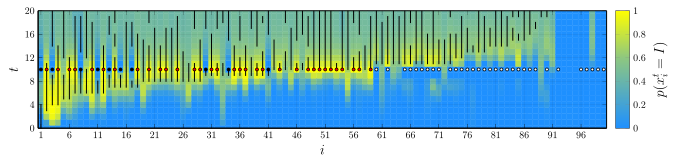

"/home/tara/julia_codes/SmallCouplingDynamicCavity/notebook/I_SCDC_autoinf_RRG_k3_900x250.pdf"

In [14]:
pgfplotsx()

cols = [:white, :red, :black]
resize_factor = 1.0
cg = cgrad([:dodgerblue, :yellow], 0.6)



plI_SCDC = heatmap(1:NV, 0:T, marg_prob_sorted_SCDC[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)#, title = "Infected")

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI_SCDC, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

for (i,t) in obslist
    scatter!(plI_SCDC, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

#println("Observations at times: ", obs_times)
plot!(plI_SCDC, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)



plI_MPBP = heatmap(1:NV, 0:T, marg_prob_sorted_MPBP[:,:,2]', c=cg, xlabel="i", ylabel="t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)#, title = "Infected")

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI_MPBP, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

for (i,t) in obslist
    scatter!(plI_MPBP, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

#println("Observations at times: ", obs_times)
plot!(plI_MPBP, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

plot!(plI_SCDC, guidefontsize=14, xtickfontsize=10, ytickfontsize=10, colorbar_tickfontsize=10, colorbar_titlefontsize=14)
display(plI_SCDC)
#display(plI_MPBP)

savefig(plI_SCDC, "I_SCDC_autoinf_ER_k3_900x250.pdf")
#savefig(plI_MPBP, "I_MPBP_autoinf_ER_k3_900x250.pdf")

In [15]:
savefig(plI_SCDC, "I_SCDC_autoinf_ER_k3_900x250.pdf")

"/home/tara/julia_codes/SmallCouplingDynamicCavity/notebook/I_SCDC_autoinf_ER_k3_900x250.pdf"